# Some Examples on Particle Swarm Optimization

### Import packages

In [1]:
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from codes.API.EM_Rasch_API import *

In [2]:
def Rasch_MMLE(particles, parameters):
    """
    Parameters
    ----------
    particles : numpy.ndarray
        sets of inputs shape :code:'(n_particles, 5)'

    parameters : numpy.ndarray
        the response matrix Y of inpus shape :code:'(N_participants, J_items)'
        the number of quadrature nodes to approximate integral :code: integer

    Returns
    ----------
    numpy.ndarray
        computed log likelihood of Gamma-Normal mixture of size :code:`(n_particles, )`
    """
    # unpack parameters
    Y, nodes_num = parameters
    N, I = Y.shape

    log_lik = np.zeros((particles.shape[0]))

    for i in range(particles.shape[0]):
        initial_value = particles[i]  # (I+1)

        # set-up parameters to be updated (parameters is an (I+1) vector)
        betas = initial_value[:I]
        sigma = np.abs(initial_value[I])

        # Gaussian-Hermite nodes and weights
        nodes, weights = np.polynomial.hermite.hermgauss(nodes_num)
        weights /= np.sqrt(np.pi)
        nodes *= np.sqrt(2)

        ### Calculate marginal log-likelihood

        # Calculate marginals: Nx1 vector
        marginal = (f_y(Y, betas, sigma, nodes) * H(nodes, fct="one")).dot(weights)

        # Calculate sum of log-likelihood
        log_lik[i] = np.sum(np.log(marginal))

    return -log_lik


In [4]:
data = np.array(pd.read_excel(r'datasets/Verbal aggression/data verbal aggression matrix dichot.xls'))
Y = data[:, :24]

N, I = np.shape(Y)
G = 1
beta_init = 0.5 * np.ones((I, G)); sigma_init = 2 * np.ones((1, G))
init_value = np.vstack((beta_init, sigma_init))

In [8]:
bounds = [tuple(np.hstack((np.repeat(-np.inf, (I+1))))),
          tuple(np.hstack((np.repeat(np.inf, (I+1)))))]

In [9]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
n = 100
init_pos = np.repeat(init_value.reshape((-1,1)), n, axis=1).T
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n, dimensions=(I+1), options=options, bounds=bounds, init_pos=init_pos)
# Perform optimization
best_cost, best_pos = optimizer.optimize(Rasch_MMLE, iters=100, parameters=(Y, 9))

2021-03-06 10:38:33,967 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.05e+3
2021-03-06 10:38:36,659 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4046.602656181962, best pos: [-1.33190723 -0.69047071 -0.19144823 -1.86479011 -0.79851835 -0.14092585
 -0.67741552  0.57364905  1.35125552 -1.22613557  0.2269713   0.89685328
 -1.34746462 -0.51900348  0.76137022 -0.98870667 -0.0628319   1.33087747
  0.08906705  1.30580834  2.82440313 -0.81898198  0.28301849  1.81543591
  1.28971088]


In [10]:
beta_init = 0.5 * np.ones((I, 1)); sigma_init = 1.5
init_value = np.vstack((beta_init, sigma_init))
nodes_num=21
betas_t=beta_init
sigma_t=sigma_init

iter_time = 10

for i in range(iter_time):
    output = fsolve(EM_Rasch, x0=init_value, args=[Y, nodes_num, betas_t,sigma_t])
    betas_t = output[:-1]; sigma_t = output[-1]
    #print(betas_t)
    #print(sigma_t)
    
bock_aitkin = Rasch_MMLE(output.reshape((1, -1)), (Y, 21))

[-1.11882433 -0.5042512  -0.05030896 -1.61299289 -0.63812651  0.01372665
 -0.47118617  0.66717874  1.45231486 -0.98864498  0.35184111  1.00154887
 -1.11882433 -0.34021037  0.84004436 -0.79256663  0.07777753  1.41027708
  0.22231901  1.43121355  2.79894649 -0.63812651  0.38444964  1.89244959]
0.9120040406141297


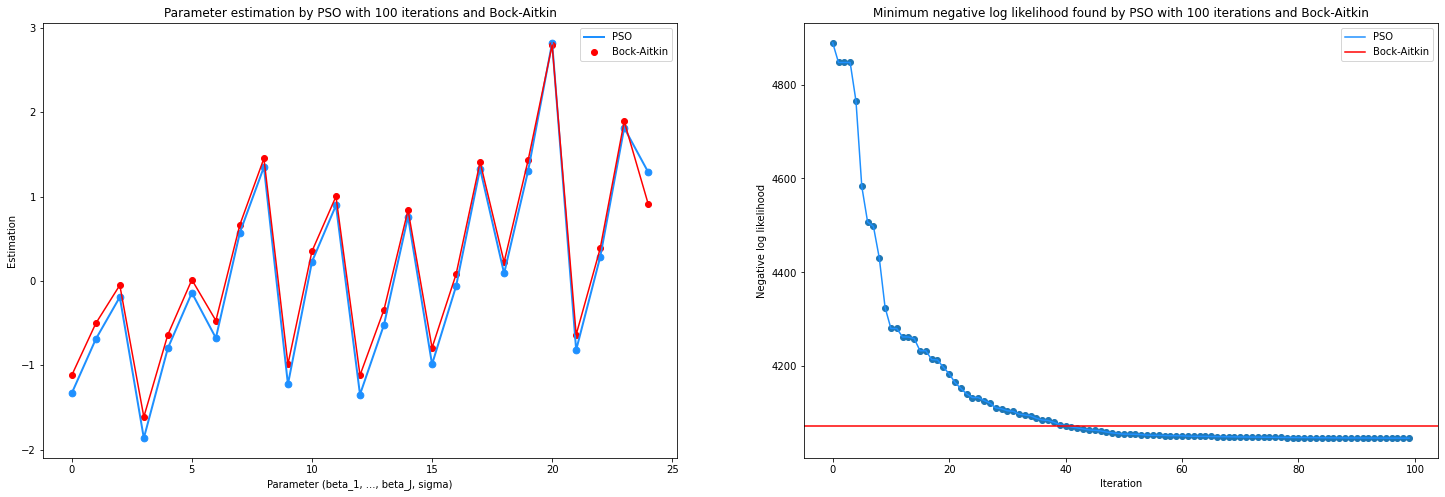

In [16]:
plt.figure(figsize=(25,8))
plt.subplot(121)
plt.plot(range(I+1), best_pos[:], c='dodgerblue', linewidth=2, label="PSO")
plt.scatter(range(I+1), best_pos[:], c="dodgerblue", s=45)
plt.scatter(range(I+1), output, c="r", linewidth=1, label="Bock-Aitkin")
plt.plot(range(I+1), output, c="r")
plt.legend()
plt.xlabel("Parameter (beta_1, ..., beta_J, sigma)")
plt.ylabel("Estimation")
plt.title("Parameter estimation by PSO with 100 iterations and Bock-Aitkin")

plt.subplot(122)
plt.plot(optimizer.cost_history, label="PSO", color="dodgerblue")
plt.scatter(range(len(optimizer.cost_history)), optimizer.cost_history, cmap='summer')
plt.axhline(y=bock_aitkin, color='r', linestyle='-', label="Bock-Aitkin")
plt.xlabel("Iteration")
plt.ylabel("Negative log likelihood")
plt.legend()
plt.title("Minimum negative log likelihood found by PSO with 100 iterations and Bock-Aitkin")

plt.show()